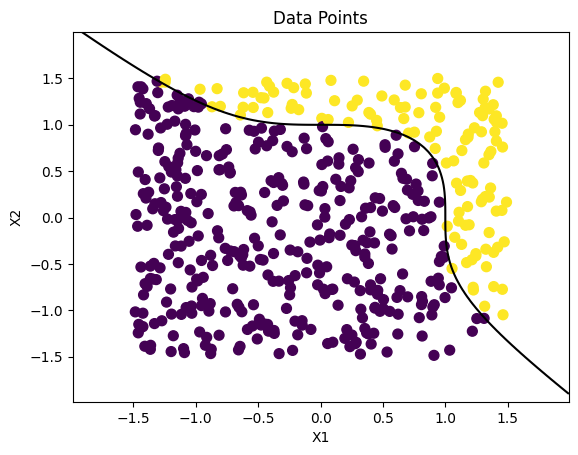

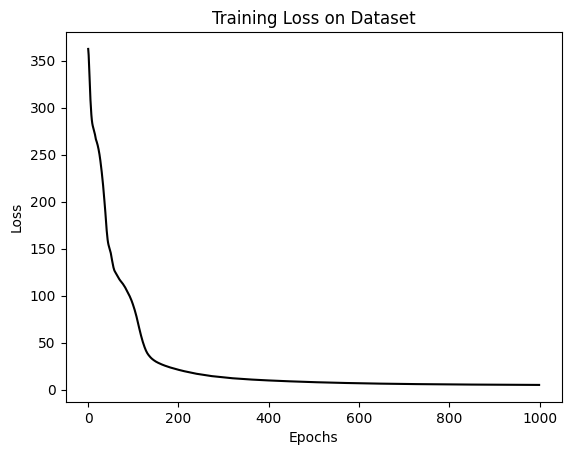

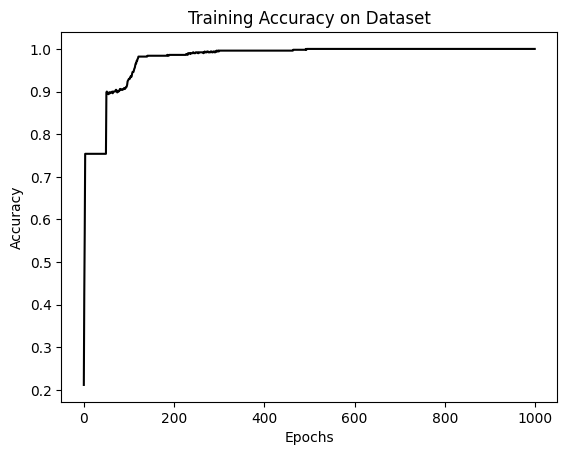

Test Accuracy: 99.15%


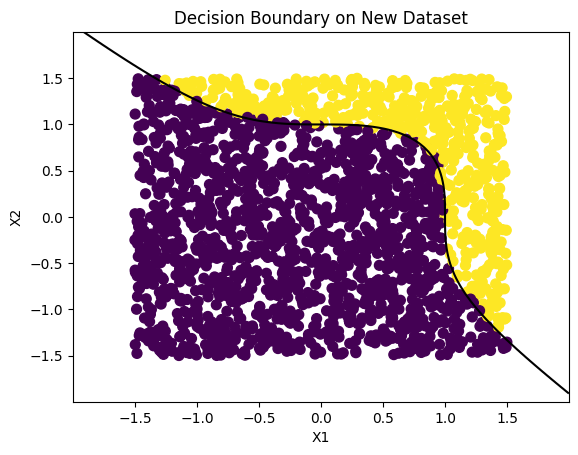

<ipython-input-6-ba3b6fb6cc32>:43: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))


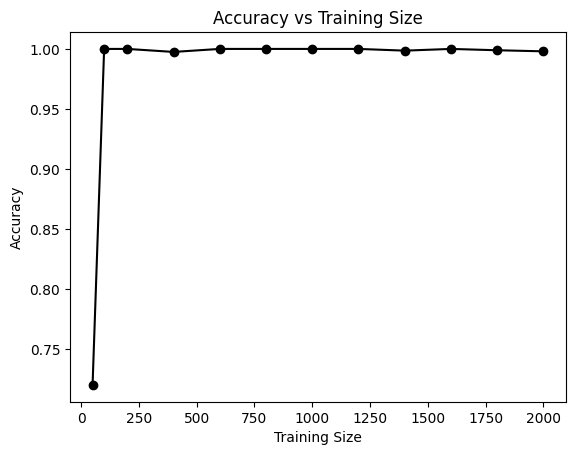

In [6]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def get_data(N=500):
    X = np.random.uniform(-1.5, 1.5, (N, 2)) #2D array for values
    T = np.where(X[:, 0]**3 + X[:, 1]**3 < 1.0, 0, 1) #2D array for x^3+y^3
    Y = np.zeros((N, 1)) #class label for T=0
    Y[T == 1] = 1 # when T=1
    return X, Y

class NN():
    def __init__(self, architecture): #initialization of layers
        self.activations = []
        self.params_values = {}
        self.layers = len(architecture)
        self.grads_momentum = {}
        for i, layer in enumerate(architecture):
            input_size, output_size, activation = layer["input_dim"], layer["output_dim"], layer["activation"]
            self.activations.append(activation)
            self.params_values[f"W{str(i)}"] = np.random.randn(
                output_size, input_size
            ) / np.sqrt(input_size)
            self.params_values[f"b{str(i)}"] = np.zeros((1, output_size))
            self.grads_momentum[f"W{str(i)}"] = np.zeros_like(self.params_values[f"W{str(i)}"])
            self.grads_momentum[f"b{str(i)}"] = np.zeros_like(self.params_values[f"b{str(i)}"])
        self.reset()

    def reset(self):#reset the gradients
        self.cache = {}
        self.grads = {}

    def leaky_relu(self, x, alpha=0.01): #negative to positive, if positive-> x and negative-> alpha* x
        return np.where(x > 0, x, x * alpha)

    def dleaky_relu(self, dA, z, alpha=0.01):
        dz = np.ones_like(z)
        dz[z < 0] = alpha
        return dA * dz

    def sigmoid(self, x):
        return 1. / (1. + np.exp(-x))

    def dsigmoid(self, dA, z):
        s = self.sigmoid(z)
        return s * (1. - s) * dA

    def bce(self, yhat, y):# binary cross entropy-> loss function
        yhat, y = yhat.flatten(), y.flatten()
        cost = -np.mean(np.dot(y, np.log(yhat+1e-8)) + np.dot((1 - y), np.log(1 - yhat+1e-8)))
        return np.squeeze(cost)

    def dbce(self, yhat, y):
        return -(y / (yhat+1e-8) - (1 - y) / (1 - yhat+1e-8))

    def single_forward(self, x, W, b, activation):# only for one layer to another layer
        Z = x @ W.T + b #preactivation value(H)
        A = getattr(self, activation)(Z) # activating after updating the weight and bias by using leaky relu
        return A, Z

    def forward(self, x): #value for from the first to the last layer
        A_prev = None
        A_curr = x
        for i in range(self.layers):
            W, b = self.params_values[f"W{str(i)}"], self.params_values[f"b{str(i)}"] # updating W and b
            activation = self.activations[i] #activating all layers
            A_prev = A_curr
            A_curr, Z_curr = self.single_forward(A_prev, W, b, activation)
            self.cache[str(i)] = (Z_curr, A_prev)
        return A_curr

    def single_backward(self, dA_curr, W, Z_curr, A_prev, activation): #only for previous layer
        m = A_prev.shape[1]
        dactivation = getattr(self, f"d{activation}") #derivative of the leaky relu activation
        dA_curr = dactivation(dA_curr, Z_curr)
        dW = np.dot(dA_curr.T, A_prev) / m
        db = np.sum(dA_curr, axis = 0, keepdims = True) / m
        dA_curr = np.dot(dA_curr, W)
        return dA_curr, dW, db

    def backward(self, yhat, y): # for all the layer from last to first
        dA_curr = self.dbce(yhat, y) #finds out the loss
        for i in range(self.layers - 1, -1, -1):
            W = self.params_values[f"W{str(i)}"] #finds out the weight
            Z_curr, A_prev = self.cache[str(i)]
            dA_curr, dW, db = self.single_backward(dA_curr, W, Z_curr, A_prev, self.activations[i]) # finds derivative for the preious one to the new one
            self.grads[f"W{str(i)}"] = dW
            self.grads[f"b{str(i)}"] = db

    def accuracy(self, yhat, y):
        prediction = np.where(yhat > 0.5, 1, 0)
        return np.mean(prediction == y)

    def train(self, x, y, learning_rate, epochs, momentum = 0.9, weight_decay = 0.0001):
        losses = []
        accuracies = []
        for _ in range(epochs): # forwarding
            yhat = self.forward(x)
            loss = self.bce(yhat, y) # finding the loss
            losses.append(loss)
            accuracy = self.accuracy(yhat, y) # accuracy
            accuracies.append(accuracy)
            self.backward(yhat, y) # backwarding the data
            self.update_params(weight_decay, momentum, learning_rate) # running this fowarding-backwarding epochs time
        return losses, accuracies

    def update_params(self, weight_decay, momentum, learning_rate): #momentum optimization
        for i in range(self.layers):
            dW = self.grads[f"W{str(i)}"] + weight_decay * self.params_values[f"W{str(i)}"]
            db = self.grads[f"b{str(i)}"] + weight_decay * self.params_values[f"b{str(i)}"]
            self.grads_momentum[f"W{str(i)}"] = momentum * self.grads_momentum[f"W{str(i)}"] + (1 - momentum) * dW
            self.grads_momentum[f"b{str(i)}"] = momentum * self.grads_momentum[f"b{str(i)}"] + (1 - momentum) * db
            self.params_values[f"W{str(i)}"] -= learning_rate * self.grads_momentum[f"W{str(i)}"]
            self.params_values[f"b{str(i)}"] -= learning_rate * self.grads_momentum[f"b{str(i)}"]
        self.reset()

X, Y = get_data()
#plotting the function
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = xx**3 + yy**3

plt.contour(xx, yy, Z, levels=[1.0], cmap="Greys_r")
plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='viridis')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Data Points')
plt.show()

nn_architecture = [
    {"input_dim": 2, "output_dim": 6, "activation": "leaky_relu"},
    {"input_dim": 6, "output_dim": 6, "activation": "leaky_relu"},
    {"input_dim": 6, "output_dim": 6, "activation": "leaky_relu"},
    {"input_dim": 6, "output_dim": 3, "activation": "leaky_relu"},
    {"input_dim": 3, "output_dim": 1, "activation": "sigmoid"},
]

nn = NN(nn_architecture)

losses, accuracies = nn.train(X, Y, 0.005, 1000, 0.9, 0.1)# Train the NN

# Plot the loss for the number of epochs
plt.plot(losses, color='black')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss on Dataset')
plt.show()

# Plot the accuracy for the number of epochs
plt.plot(accuracies, color='black')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy on Dataset')
plt.show()

# Plot the decision boundary
X_test, Y_test = get_data(2000)  # Use the new data generation function
yhat = nn.forward(X_test)
yhat = np.where(yhat > 0.5, 1, 0)  # Convert probabilities to binary predictions

# Calculate the accuracy
test_accuracy = nn.accuracy(yhat, Y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot the decision boundary
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = xx**3 + yy**3

plt.contour(xx, yy, Z, levels=[1.0], cmap="Greys_r")
plt.scatter(X_test[:, 0], X_test[:, 1], c=yhat.flatten(), s=50, cmap='viridis')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Decision Boundary on New Dataset')
plt.show()


# Training sizes to evaluate
training_sizes = [50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
accuracies_vs_size = []

for size in training_sizes:
    X_train, Y_train = get_data(size)
    nn = NN(nn_architecture)
    _, accuracies = nn.train(X_train, Y_train, 0.005, 1000, 0.9, 0.1)
    final_accuracy = accuracies[-1]
    accuracies_vs_size.append(final_accuracy)

# Plot accuracy vs training size
plt.plot(training_sizes, accuracies_vs_size, marker='o', color='black')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Training Size')
plt.show()
